To analyze the effect of the independent variables on the outcome/dependent variable (bleeding) wholistically, must perform a multivariate analysis. A logistic regression model is a suitable choice for a dataset with a binary outcome. I'll explore partioning the outcome data in three different ways: 

1. The binary outcome is Major vs. Minor bleeding
2. The binary outcome is:
Major vs. Minor + None bleeding, 
Major + Minor vs. None bleeding,
Major vs. None, 
Minor vs. None,
Major vs. Minor

3. The ternary outcome is Major vs. Minor vs. None (will have to use a multinomial classification model for this: Multinomial logistic regression or Linear discriminant analysis) 

The independent variables that will be implemented into this model are: 
- age of diagnosis, gender, platelet count, anti-coagulation, antiplatelet, invasive procedure (which I believe is PMHx bleeding risk), (maybe INR later), Molecular/cytogenetics, anemia, prior lines of therapy, 

Continuing with 2

Import necessary libraries 

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import imblearn
from imblearn.over_sampling import SMOTE

print("complete")

complete


Read dataset

In [2]:
df = pd.read_csv("/Users/anthonyquint/Desktop/LHSC_Work_Folder/Mina/Bleeding_study/Ibrutinib Data Set, June 10,2021, de- identified data.csv")
df.head()

,Age at diagnosis,gender,Diagnosis year,Plt at diagnosis,plt at start of ibrutinib,plt at the time of bleed,Plt Nadir while on Ibrutinib,Platelets < 50 (Y/N),hb at diognosis,hb at start of Ibrutinib,...,action?,post op bleed? /action,INR,past medical history,PMHx bleeding risk (Y/N),Ibrutinib Dose,Comments,other ibrutinib SE,Unnamed: 43,Unnamed: 44
0,48,f,2006,260,15,NaN,15,Y,130,71,...,NaN,NaN,NaN,"deppression, schwanoma of leg",Y,"420mg,",ITP at the time of starting ibrutinib,NaN,NaN,NaN
1,66,m,2017,175,83,155,93,N,145,93,...,NaN,NaN,NaN,"cryoglobinemia,MGUS,CAD,HTN,COPD",N,420mg,NaN,NaN,NaN,NaN
2,74,F,2016,189,200,NaN,nl plts,N,116,87,...,NaN,NaN,NaN,"dm2,htn,",N,"420mg,",reaction to first obino so switched to ibrutin...,NaN,NaN,NaN
3,53,F,2002,237,67,NaN,40,Y,135,118,...,NaN,NaN,NaN,"HTN,B12 def,IDA",N,420mg,WAIHA,easy bruising,NaN,NaN
4,60,m,1999,198,85,70,49,Y,154,104,...,died,NaN,1.1,"prostitis,mycosis,chronc sinusitis",N,ibrutinib dose reduced to 140 in oct 2015 for ...,"cutaneous oral mucosal involvement w CLL, als...",NaN,NaN,NaN


Cleaning the dataset, and select which two groups to compare: 

Major vs. Minor + None bleeding, 
Major + Minor vs. None bleeding,
Major vs. None, 
Minor vs. None,
Major vs. Minor

In [3]:
#Removing all columns except the columns corresponding to our relevant 
#independent variables (indicated at top of notebook) and dependent variable (Major Bleed (Y/N))

df = df[["Age at diagnosis","gender","Platelets < 50 (Y/N)","Anemia (hb < 110) (Y/N)", "HR Molecular/Cytogenetics (Y/N)","Prior lines of therapy","anticoagulation (Y/N)","anti platelet (Y/N)","PMHx bleeding risk (Y/N)","Major Bleed (Y/N)"]]

#Gender has inputs of F or M, but sometimes they are lowercase. Using "upper()" to ensure they are all uppercase

df['gender'] = df['gender'].str.upper()

# removing rows that have "Unknown" cytogenetics.  #Doing this didn't improve results. 
# df = df[~df['HR Molecular/Cytogenetics (Y/N)'].isin(['unknown'])] 

## Major vs. Minor 
#df = df.dropna().copy() 

#Major vs. Minor + None bleeding
#changing NaN values in "Major Bleed (Y/N)" to N 
#df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Major + Minor vs. None 
#changing "N" values to Y, and NaN values to N. 
df['Major Bleed (Y/N)'] = df['Major Bleed (Y/N)'].replace(['N'],'Y')
df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Major vs. None
#df = df[~df['Major Bleed (Y/N)'].isin(['N'])] 
#df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Minor vs. None
#df = df[~df['Major Bleed (Y/N)'].isin(['Y'])] 
#df['Major Bleed (Y/N)'] = df['Major Bleed (Y/N)'].replace(['N'],'Y')
#df['Major Bleed (Y/N)'].fillna('N', inplace=True)

# Delete index 112 since it has a question mark for age 
df = df.drop(labels=112, axis=0)

df.head()

,Age at diagnosis,gender,Platelets < 50 (Y/N),Anemia (hb < 110) (Y/N),HR Molecular/Cytogenetics (Y/N),Prior lines of therapy,anticoagulation (Y/N),anti platelet (Y/N),PMHx bleeding risk (Y/N),Major Bleed (Y/N)
0,48,F,Y,Y,Y,1,N,N,Y,N
1,66,M,N,Y,Y,0,N,Y,N,Y
2,74,F,N,Y,Y,1,N,N,N,N
3,53,F,Y,N,N,2,N,N,N,N
4,60,M,Y,Y,N,3,N,N,N,Y


Counting number of people who had major vs. minor bleed

In [4]:
df['Major Bleed (Y/N)'].value_counts(dropna=False)   #Counting number of people who had major vs. minor bleed

## should 0 and 1 appear roughly at equal frequencies? ##

N    127
Y     42
Name: Major Bleed (Y/N), dtype: int64

Converting categorical data into numerical representation

In [5]:
number = LabelEncoder()
df['gender'] = number.fit_transform(df['gender'].astype('str'))
df['Platelets < 50 (Y/N)'] = number.fit_transform(df['Platelets < 50 (Y/N)'].astype('str'))
df['Anemia (hb < 110) (Y/N)'] = number.fit_transform(df['Anemia (hb < 110) (Y/N)'].astype('str'))
df['HR Molecular/Cytogenetics (Y/N)'] = number.fit_transform(df['HR Molecular/Cytogenetics (Y/N)'].astype('str'))
df['anticoagulation (Y/N)'] = number.fit_transform(df['anticoagulation (Y/N)'].astype('str'))
df['anti platelet (Y/N)'] = number.fit_transform(df['anti platelet (Y/N)'].astype('str'))
df['PMHx bleeding risk (Y/N)'] = number.fit_transform(df['PMHx bleeding risk (Y/N)'].astype('str'))
df['Major Bleed (Y/N)'] = number.fit_transform(df['Major Bleed (Y/N)'].astype('str'))


df.head()

,Age at diagnosis,gender,Platelets < 50 (Y/N),Anemia (hb < 110) (Y/N),HR Molecular/Cytogenetics (Y/N),Prior lines of therapy,anticoagulation (Y/N),anti platelet (Y/N),PMHx bleeding risk (Y/N),Major Bleed (Y/N)
0,48,0,1,1,1,1,0,0,1,0
1,66,1,0,1,1,0,0,1,0,1
2,74,0,0,1,1,1,0,0,0,0
3,53,0,1,0,0,2,0,0,0,0
4,60,1,1,1,0,3,0,0,0,1


Splitting data into independent and dependent variables, then into training and testing set, and then upsample the training sets

In [6]:
clinical_features = ['Age at diagnosis','gender','Platelets < 50 (Y/N)','Anemia (hb < 110) (Y/N)','HR Molecular/Cytogenetics (Y/N)','Prior lines of therapy','anticoagulation (Y/N)','anti platelet (Y/N)','PMHx bleeding risk (Y/N)']
#clinical_features = ['Age at diagnosis','gender','Platelets < 50 (Y/N)','Anemia (hb < 110) (Y/N)','Prior lines of therapy','anticoagulation (Y/N)','anti platelet (Y/N)','PMHx bleeding risk (Y/N)']

X = df[clinical_features]   #Independent variables 
y = df['Major Bleed (Y/N)']  #Dependent variables 

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0,stratify=y) #Splitting variables into training/testing set

X_Y_train = pd.concat([X_train,y_train],axis=1)

def upsample_minority(df):
    
    df_majority = df.loc[df['Major Bleed (Y/N)'] == 0]
    df_minority = df.loc[df['Major Bleed (Y/N)'] == 1]
    
    df_minority_upsampled = resample(df_minority, replace = True, n_samples=len(df_majority), random_state=123)
    df_upsampled = pd.concat([df_majority,df_minority_upsampled])
    
    df = df_upsampled
    
    return df 

def smote(train_1,train_2):
    
    sm = SMOTE(random_state=27)
    train_1, train_2 = sm.fit_resample(train_1, train_2)
    
    return train_1,train_2 

#upsampling the minority directly
X_Y_train_upsample = upsample_minority(X_Y_train)
y_train_upsample = X_Y_train_upsample['Major Bleed (Y/N)']
X_train_upsample = X_Y_train_upsample.drop('Major Bleed (Y/N)', axis=1)

df_upsample = upsample_minority(df)
y_upsample = df_upsample['Major Bleed (Y/N)']
X_upsample = df_upsample.drop('Major Bleed (Y/N)', axis=1)

#upsampling by generating synthetic samples (smote)
X_train_smote, y_train_smote = smote(X_train, y_train)

X_smote, y_smote = smote(X, y)

# Choosing which of the 2 sets of upsampled data I'll make the model with (upsampling vs. smote). 
# Upsampling produces better results
XX = X_train_upsample
yy = y_train_upsample

## https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Training the model with statsmodel

In [7]:
logit_model_1=sm.Logit(yy,sm.add_constant(XX.astype(float)))
#logit_model_1=sm.Logit(y,sm.add_constant(X.astype(float)))

result_1=logit_model_1.fit()
print(result_1.summary())

Optimization terminated successfully.
         Current function value: 0.593690
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      Major Bleed (Y/N)   No. Observations:                  190
Model:                          Logit   Df Residuals:                      180
Method:                           MLE   Df Model:                            9
Date:                Fri, 02 Jul 2021   Pseudo R-squ.:                  0.1435
Time:                        14:53:20   Log-Likelihood:                -112.80
converged:                       True   LL-Null:                       -131.70
Covariance Type:            nonrobust   LLR p-value:                 1.898e-05
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.6724      1.234     -2.166  

In [8]:
np.exp(result_1.params) #Converting the coefficients (log odds) into the odds

const                              0.069084
Age at diagnosis                   1.015623
gender                             1.363036
Platelets < 50 (Y/N)               1.109509
Anemia (hb < 110) (Y/N)            1.797747
HR Molecular/Cytogenetics (Y/N)    1.504639
Prior lines of therapy             1.258677
anticoagulation (Y/N)              8.639858
anti platelet (Y/N)                1.847683
PMHx bleeding risk (Y/N)           0.589390
dtype: float64

Dropping insignficant data

In [9]:
# For x y train upsample: 

####FIGURE OUT WHAT TO DROP LATER
# Dropping: gender, prior lines of ..., anti plat, PMH risk, gives ROC score of 0.56 ish. 

#constant is not significant, but ill still keep it in 
XX = XX.drop(['Age at diagnosis'],axis=1)
XX = XX.drop(['gender'],axis=1)
XX = XX.drop(['Platelets < 50 (Y/N)'],axis=1)
XX = XX.drop(['Anemia (hb < 110) (Y/N)'],axis=1)
XX = XX.drop(['HR Molecular/Cytogenetics (Y/N)'],axis=1)
XX = XX.drop(['Prior lines of therapy'],axis=1)
#XX = XX.drop(['anticoagulation (Y/N)'],axis=1)
XX = XX.drop(['anti platelet (Y/N)'],axis=1)
XX = XX.drop(['PMHx bleeding risk (Y/N)'],axis=1)

X_test = X_test.drop(['Age at diagnosis'],axis=1)
X_test = X_test.drop(['gender'],axis=1)
X_test = X_test.drop(['Platelets < 50 (Y/N)'],axis=1)
X_test = X_test.drop(['Anemia (hb < 110) (Y/N)'],axis=1)
X_test = X_test.drop(['HR Molecular/Cytogenetics (Y/N)'],axis=1)
X_test = X_test.drop(['Prior lines of therapy'],axis=1)
#X_test = X_test.drop(['anticoagulation (Y/N)'],axis=1)
X_test = X_test.drop(['anti platelet (Y/N)'],axis=1)
X_test = X_test.drop(['PMHx bleeding risk (Y/N)'],axis=1)



# For x y train smote 
#XX = XX.drop(['Age at diagnosis'],axis=1)
#XX = XX.drop(['Anemia (hb < 110) (Y/N)'],axis=1)
#XX = XX.drop(['anti platelet (Y/N)'],axis=1)
#XX = XX.drop(['HR Molecular/Cytogenetics (Y/N)'],axis=1)
#XX = XX.drop(['anticoagulation (Y/N)'],axis=1)
#XX = XX.drop(['PMHx bleeding risk (Y/N)'],axis=1)

#X_test = X_test.drop(['Age at diagnosis'],axis=1)
#X_test = X_test.drop(['Anemia (hb < 110) (Y/N)'],axis=1)
#X_test = X_test.drop(['anti platelet (Y/N)'],axis=1)
#X_test = X_test.drop(['HR Molecular/Cytogenetics (Y/N)'],axis=1)
#X_test = X_test.drop(['anticoagulation (Y/N)'],axis=1)
#X_test = X_test.drop(['PMHx bleeding risk (Y/N)'],axis=1)



Using statsmodel again to refit the model without the uncorrelated variables, then evaluating the model

In [10]:
## gonna decide what best to drop later,

logit_model_2=sm.Logit(yy,sm.add_constant(XX.astype(float)))


result_2=logit_model_2.fit()
print(result_2.summary())

ypredict = result_2.predict(sm.add_constant(X_test.astype(float)))
prediction = list(map(round,ypredict))

cnf_matrix_1 = metrics.confusion_matrix(y_test,prediction)
cnf_matrix_1

Optimization terminated successfully.
         Current function value: 0.621590
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Major Bleed (Y/N)   No. Observations:                  190
Model:                          Logit   Df Residuals:                      188
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 Jul 2021   Pseudo R-squ.:                  0.1032
Time:                        14:53:20   Log-Likelihood:                -118.10
converged:                       True   LL-Null:                       -131.70
Covariance Type:            nonrobust   LLR p-value:                 1.843e-07
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4537      0.174     -2.607      0.009      -0.795      -0.

array([[27,  5],
       [ 7,  4]])

Text(0.5, 257.44, 'Predicted label')

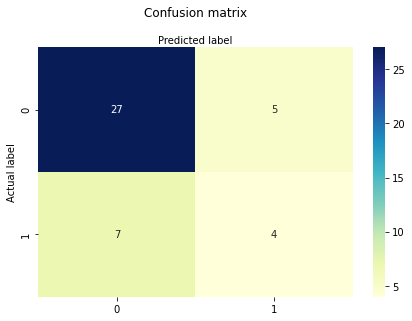

In [11]:
#Visualizing accuracy with heatmap 
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [12]:
print("Accuracy:",metrics.accuracy_score(y_test, prediction))
print("Precision:",metrics.precision_score(y_test, prediction))
print("Recall:",metrics.recall_score(y_test, prediction))

Accuracy: 0.7209302325581395
Precision: 0.4444444444444444
Recall: 0.36363636363636365


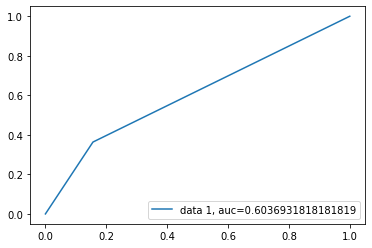

In [13]:
#ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test,  ypredict)
auc = metrics.roc_auc_score(y_test, ypredict)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Training the model with LogisticRegression

In [14]:
# instantiate the model (using the default parameters) (using LogisticRegression)
logreg = LogisticRegression(max_iter=200)

# fit the model with data
logreg.fit(XX,yy)

#
y_pred=logreg.predict(X_test)
#y_pred

Model Evaluation

In [15]:
cnf_matrix_2 = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_2   # Viewing accuracy of model 

array([[27,  5],
       [ 7,  4]])

Text(0.5, 257.44, 'Predicted label')

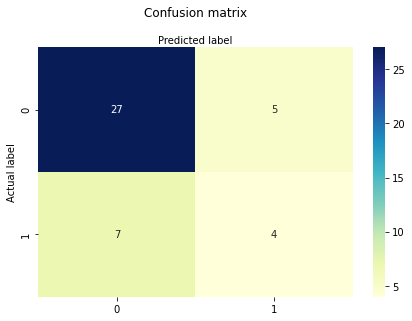

In [16]:
#Visualizing accuracy with heatmap 
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [17]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7209302325581395
Precision: 0.4444444444444444
Recall: 0.36363636363636365


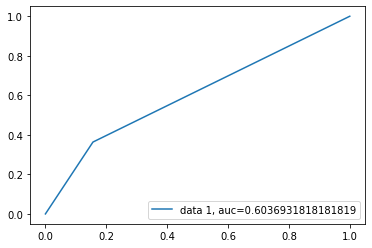

In [18]:
#ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()